Disclaimer: The data is about Asteroids – NeoWs (Near Earth Object Web Service. It is a RESTful
web service for near earth Asteroid information. With NeoWs a user can: search for Asteroids based
on their closest approach date to Earth, lookup a specific Asteroid with its NASA JPL small body id, as
well as browse the overall dataset. Inspiration is to find potential hazardous, non-hazardous
asteroids and features responsible for claiming an asteroid to be hazardous.
Dataset description: It has 4687 rows of data and 40 different columns.
Dataset link: https://www.kaggle.com/shrutimehta/nasa-asteroids-classification
Task: In this notebook, the use of the 'xgboost' algorithm for classification is demonstrated. The
scope of this case study is to predict whether an asteroid can be hazardous or not based on its
characteristics/properties using XGBClassier , BayesianOptimization and RandomizedSearchCV
function.

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

In [12]:
data=pd.read_csv('files/nasa.csv')
df=data.copy()
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [13]:
df.shape

(4687, 40)

In [14]:
df.columns

Index(['Neo Reference ID', 'Name', 'Absolute Magnitude', 'Est Dia in KM(min)',
       'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)',
       'Est Dia in Miles(min)', 'Est Dia in Miles(max)',
       'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbiting Body',
       'Orbit ID', 'Orbit Determination Date', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination',
       'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance',
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',
       'Mean Motion', 'Equinox', 'Hazardous'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

In [16]:
df.drop(['Orbit Determination Date','Close Approach Date','Name','Neo Reference ID'],axis=1, inplace=True)

In [17]:
df['Orbiting Body'].value_counts()

Earth    4687
Name: Orbiting Body, dtype: int64

In [18]:
for i in df.columns:
    print(i,data[i].nunique())

Absolute Magnitude 269
Est Dia in KM(min) 269
Est Dia in KM(max) 269
Est Dia in M(min) 269
Est Dia in M(max) 269
Est Dia in Miles(min) 269
Est Dia in Miles(max) 269
Est Dia in Feet(min) 269
Est Dia in Feet(max) 269
Epoch Date Close Approach 777
Relative Velocity km per sec 4687
Relative Velocity km per hr 4687
Miles per hour 4687
Miss Dist.(Astronomical) 4673
Miss Dist.(lunar) 4660
Miss Dist.(kilometers) 4661
Miss Dist.(miles) 4660
Orbiting Body 1
Orbit ID 188
Orbit Uncertainity 10
Minimum Orbit Intersection 3678
Jupiter Tisserand Invariant 2495
Epoch Osculation 429
Eccentricity 3692
Semi Major Axis 3692
Inclination 3692
Asc Node Longitude 3692
Orbital Period 3692
Perihelion Distance 3692
Perihelion Arg 3692
Aphelion Dist 3692
Perihelion Time 3692
Mean Anomaly 3692
Mean Motion 3692
Equinox 1
Hazardous 2


In [19]:
df.drop(['Orbiting Body','Equinox'],axis=1, inplace=True) # all values are the same

In [20]:
df.columns=df.columns.str.replace(" ","_")

<AxesSubplot:>

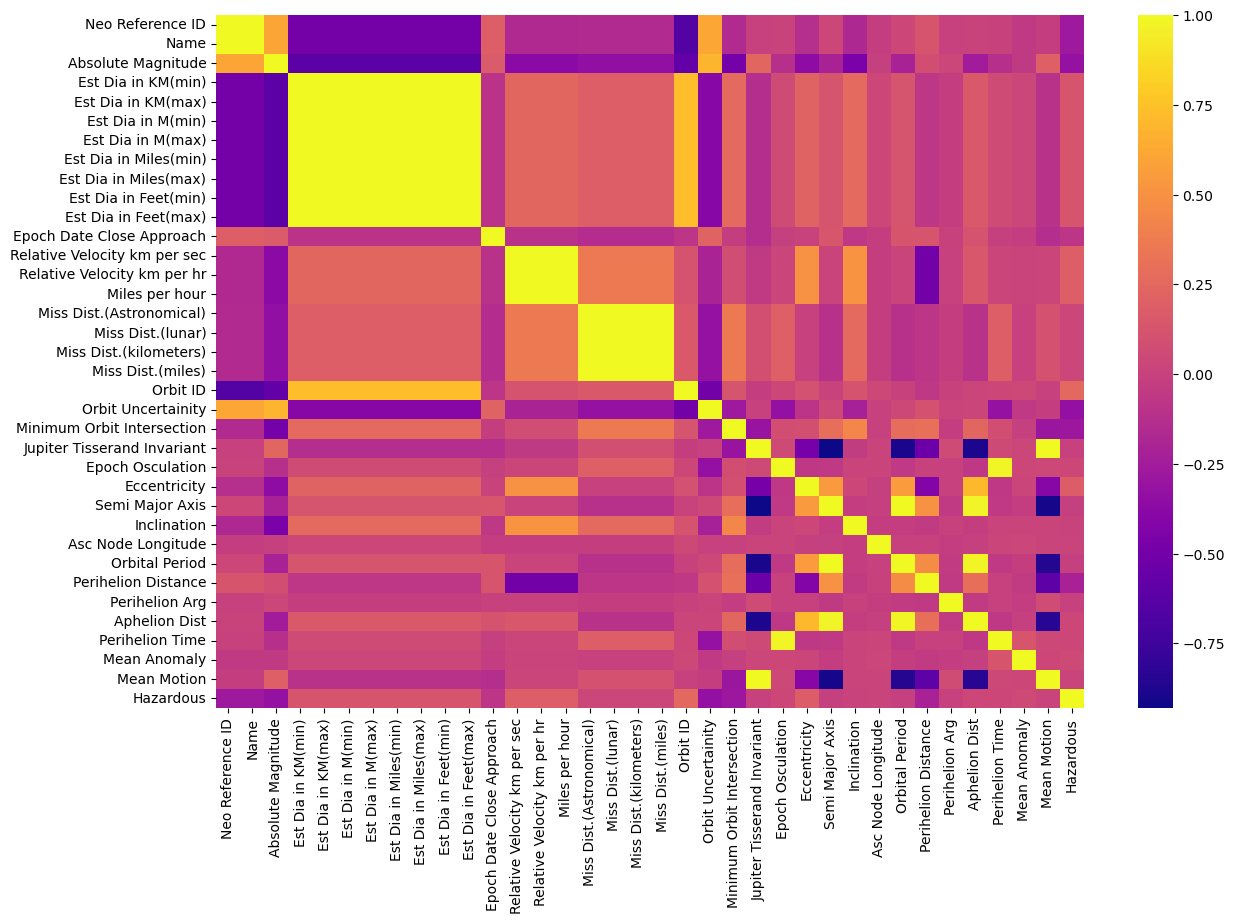

In [21]:
plt.figure(figsize=(14,9))
sns.heatmap(data.corr(),cmap='plasma')

Text(0.5, 1.0, "Correlatyuion of the variables to 'Hazardous' feature")

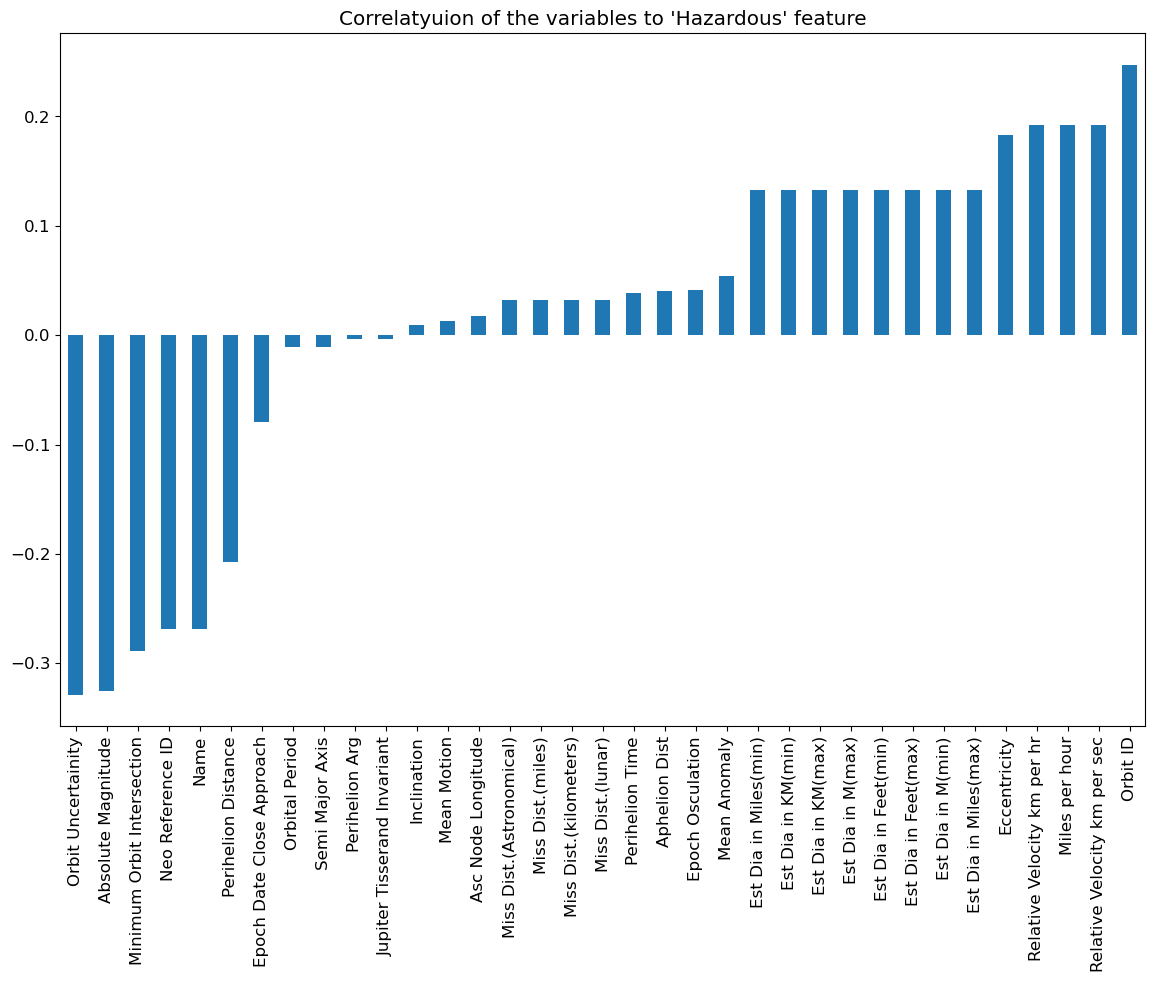

In [22]:
plt.figure(figsize=(14,9))
plt.rcParams['font.size']=12
data.corr()['Hazardous'].sort_values().drop('Hazardous').plot(kind='bar')
plt.title("Correlatyuion of the variables to 'Hazardous' feature")

In [23]:
df.drop(['Est_Dia_in_KM(min)', 'Est_Dia_in_KM(max)','Est_Dia_in_M(min)', 'Est_Dia_in_M(max)', 'Est_Dia_in_Miles(min)',
       'Est_Dia_in_Miles(max)', 'Est_Dia_in_Feet(min)', 'Est_Dia_in_Feet(max)','Miss_Dist.(miles)','Miss_Dist.(Astronomical)', 
         'Miss_Dist.(lunar)','Relative_Velocity_km_per_hr'],axis=1, inplace=True)

In [24]:
df.shape

(4687, 22)

In [25]:
df.head()

,Absolute_Magnitude,Epoch_Date_Close_Approach,Relative_Velocity_km_per_sec,Miles_per_hour,Miss_Dist.(kilometers),Orbit_ID,Orbit_Uncertainity,Minimum_Orbit_Intersection,Jupiter_Tisserand_Invariant,Epoch_Osculation,...,Inclination,Asc_Node_Longitude,Orbital_Period,Perihelion_Distance,Perihelion_Arg,Aphelion_Dist,Perihelion_Time,Mean_Anomaly,Mean_Motion,Hazardous
0,21.6,788947200000,6.115834,13680.509944,62753692.0,17,5,0.025282,4.634,2458000.5,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,21.3,788947200000,18.113985,40519.173105,57298148.0,21,3,0.186935,5.457,2458000.5,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,20.3,789552000000,7.590711,16979.661798,7622911.5,22,0,0.043058,4.557,2458000.5,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,27.4,790156800000,11.173874,24994.839864,42683616.0,7,6,0.005512,5.093,2458000.5,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,21.6,790156800000,9.840831,22012.954985,61010824.0,25,1,0.034798,5.154,2458000.5,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True


In [26]:
encoder= LabelBinarizer()
df['Hazardous']=encoder.fit_transform(df['Hazardous'])

In [27]:
df['Hazardous'].value_counts()

0    3932
1     755
Name: Hazardous, dtype: int64

In [28]:
X=df.drop('Hazardous',axis=1)
y=df['Hazardous']

In [29]:
scaler=RobustScaler()
X_columns=X.columns
X=scaler.fit_transform(X)
X=pd.DataFrame(X,columns=X_columns)

In [30]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=0, stratify=y)

In [31]:
xgb=XGBClassifier(use_label_encoder=False)

xgb_pred_train=xgb.fit(X_train,y_train).predict(X_train)
xgb_pred_test=xgb.predict(X_test)

In [32]:
xgb_prob_pred = xgb.predict_proba(X_test)
xgb_prob_pred

array([[9.9992138e-01, 7.8604564e-05],
       [9.9982023e-01, 1.7977311e-04],
       [9.9972981e-01, 2.7021675e-04],
       ...,
       [9.9991477e-01, 8.5244348e-05],
       [1.6979754e-02, 9.8302025e-01],
       [9.9969846e-01, 3.0153606e-04]], dtype=float32)

In [33]:
print(classification_report(xgb_pred_train,y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3145
           1       1.00      1.00      1.00       604

    accuracy                           1.00      3749
   macro avg       1.00      1.00      1.00      3749
weighted avg       1.00      1.00      1.00      3749



In [34]:
print(classification_report(xgb_pred_test,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       785
           1       0.99      0.98      0.99       153

    accuracy                           1.00       938
   macro avg       0.99      0.99      0.99       938
weighted avg       1.00      1.00      1.00       938



In [35]:
model=XGBClassifier(random_state=2)

In [36]:
search_spaces={'learning_rate': Real(0.01,1.0,'uniform'),
              'max_depth': Integer(2,12),
              'subsample': Real(0.01,1.0,'uniform'),
              'colsample_bytree': Real(0.01,1.0,'uniform'),
              'reg_lambda' :Real(1e-9,100.,'uniform'),
              'reg_alpha' :Real(1e-9,100.,'uniform'),
              'n_estimators' : Integer(50,5000)}

In [42]:
opt=BayesSearchCV(estimator=model,
                 search_spaces=search_spaces,
                 scoring='accuracy',
                 n_iter=11,
                 n_points=1,
                 n_jobs=1, # nece is gortyur xbtyurda 1 ctyunki accctyuractyu ile isleir ancaq
                 return_train_score=False,
                 refit=True, # tyueniden fit olmaqa icaze
                 optimizer_kwargs={'base_estimator' :'GP'},
                 random_state=2)

In [43]:
_=opt.fit(X_train,y_train)

In [44]:
print(opt.best_params_)

OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.8968740336785366), ('max_depth', 9), ('n_estimators', 281), ('reg_alpha', 1e-09), ('reg_lambda', 66.27789001617954), ('subsample', 0.45226909919697966)])


In [45]:
y_pred_train_boosted=opt.predict(X_train)

In [46]:
print(classification_report(y_pred_train_boosted,y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3145
           1       1.00      1.00      1.00       604

    accuracy                           1.00      3749
   macro avg       1.00      1.00      1.00      3749
weighted avg       1.00      1.00      1.00      3749

